In [1]:
# Load the libraries that will be used in the main Julia process
using Distributed, Plots

In [2]:
# If, for example we started on an ml.c5.9xlarge instance, we'll have 36 vCPUs / 18 physical cores. Let's add 17 worker processes.
# Note, these processes could be running on other machines as well. If we were running a script at the command line we could use the -pN flag as well: 
# (https://docs.julialang.org/en/v1/manual/parallel-computing/index.html#Multi-Core-or-Distributed-Processing-1)
addprocs(17)

15-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

In [3]:
# Since each worker will need to be able to load a NetCDF dataset, we can use the @everywhere macro to load the NCDataset package in all our workers
@everywhere using NCDatasets

In [4]:
# Use the 'find' command to generate a list of paths for our data. The 'noaa-goes16' S3 bucket should have been mounted when our notebook instance started.
nc_list = filter(
    x -> x != "",
    split(read(`find /mnt/noaa-goes16/ABI-L2-RRQPEF/2020/ -type f`, String), "\n")
)

28222-element Array{SubString{String},1}:
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/00/OR_ABI-L2-RRQPEF-M6_G16_s20200010000216_e20200010009524_c20200010010034.nc"
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/00/OR_ABI-L2-RRQPEF-M6_G16_s20200010010216_e20200010019524_c20200010020035.nc"
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/00/OR_ABI-L2-RRQPEF-M6_G16_s20200010020216_e20200010029524_c20200010030028.nc"
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/00/OR_ABI-L2-RRQPEF-M6_G16_s20200010030216_e20200010039524_c20200010040050.nc"
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/00/OR_ABI-L2-RRQPEF-M6_G16_s20200010040216_e20200010049524_c20200010050040.nc"
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/00/OR_ABI-L2-RRQPEF-M6_G16_s20200010050216_e20200010059524_c20200010100027.nc"
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/01/OR_ABI-L2-RRQPEF-M6_G16_s20200010100216_e20200010109524_c20200010110037.nc"
 "/mnt/noaa-goes16/ABI-L2-RRQPEF/2020/001/01/OR_ABI-L2-RRQPEF-M6_G16_s20200010110216_e20200010119524_c202000101

In [5]:
# Create a function that will read the NetCDF dataset, extract the relevant variable, replace missing data with zeros; and close the file.
# This needs to be distributed to all worker processes with the @everwhere macro
@everywhere function read_rrqpe(path)::Array{Float32,2}
    Dataset(path, "r") do ds
        nomissing(ds["RRQPE"][:,:], 0)
    end
end

In [6]:
# Perform our addition as a parallel reduction operation.
# Note we can suppress the output by ending our statement with a semicolon.
res = @distributed (+) for i in nc_list
    read_rrqpe(i)
end;

In [7]:
res

5424×5424 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [8]:
res_transform = res / 6 # units are in mm/hr, but at 10 min sample, so we must divide by 6 for hourly measure
res_transform = reverse(transpose(res_transform), dims = 1) # array is transposed and flipped
res_transform[findall(x -> x > 10000, res_transform)] .= 10000 # systematic bias at extreme off nadir, so limiting to 10k
res_transform = convert(Array{Union{Missing,Float32}}, res_transform) # setting to missing requires union type
# Zeroes outside the disk of Earth are true missing, but other areas may be true zeroes. Could also use a single file to "mask",
# which would result in less noise within the disk.
res_transform[findall(x -> x == 0.0, res_transform)] .= missing

6774609-element view(::Array{Union{Missing, Float32},2}, CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(5415, 5424), CartesianIndex(5416, 5424), CartesianIndex(5417, 5424), CartesianIndex(5418, 5424), CartesianIndex(5419, 5424), CartesianIndex(5420, 5424), CartesianIndex(5421, 5424), CartesianIndex(5422, 5424), CartesianIndex(5423, 5424), CartesianIndex(5424, 5424)]) with eltype Union{Missing, Float32}:
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 ⋮
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing
 missing

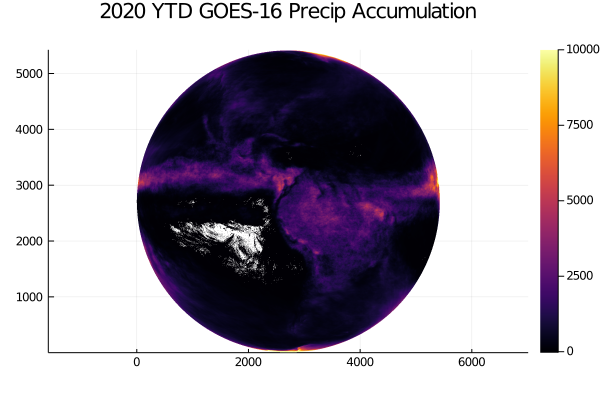

In [10]:
heatmap(res_transform, color=:inferno, aspect_ratio = 1, title = "2020 YTD GOES-16 Precip Accumulation")